In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn import metrics

In [2]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


# Importacion de datos

In [3]:
data = pd.read_csv('data_titanic_proyecto.csv')
data

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,S,Middle,M,N
887,888,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S,Upper,F,Y
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,S,Lower,F,N
889,890,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,C,Upper,M,Y


## Filtro de caracteristicas generales

In [4]:
data = data[['Age','SibSp','Parch','Fare','Cabin','Embarked','passenger_class','passenger_sex','passenger_survived']]

## Analisis de valores faltantes

In [5]:
#Porcentaje de valores faltantes
nas=data.isnull().sum()/len(data)*100
nas[nas>0]

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

### Imputacion de media para valores faltantes en Age

C:\Users\cesar\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


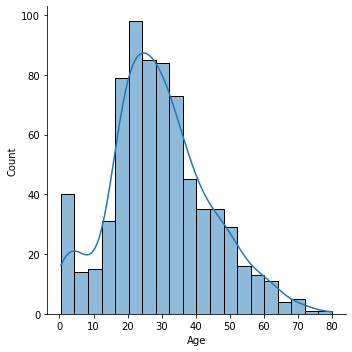

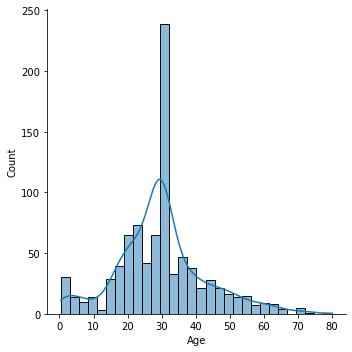

In [6]:
sns.displot(data, x="Age", kde=True)
data.loc[data.Age.isnull(),'Age'] = data['Age'].mean()
sns.displot(data, x="Age", kde=True)

### Descartamos Cabin ya que no se posee el 77% de los datos

In [7]:
data = data.drop(columns=['Cabin'])
data.head(5)

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,S,Lower,M,N
1,38.0,1,0,71.2833,C,Upper,F,Y
2,26.0,0,0,7.9250,S,Lower,F,Y
3,35.0,1,0,53.1000,S,Upper,F,Y
4,35.0,0,0,8.0500,S,Lower,M,N


### Descartamos las observaciones que no poseen Embarked ya que no supera el 0.5%

In [8]:
data = data.dropna()
data.isnull().sum()

Age                   0
SibSp                 0
Parch                 0
Fare                  0
Embarked              0
passenger_class       0
passenger_sex         0
passenger_survived    0
dtype: int64

## Split de datos de entrenamiento y pruebas

In [9]:
train, test = train_test_split(data, test_size=0.1)

# EDA
## Distribucion de variables

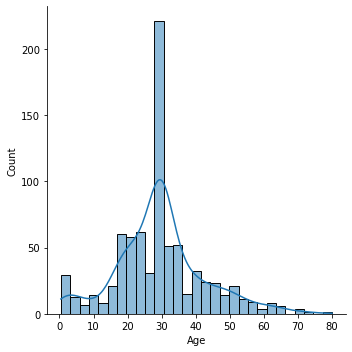

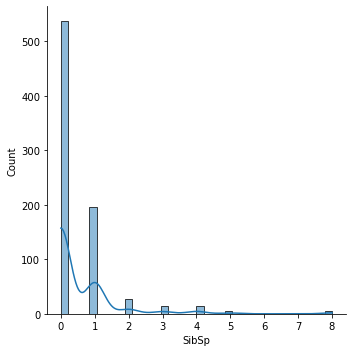

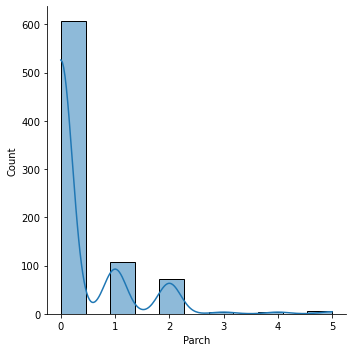

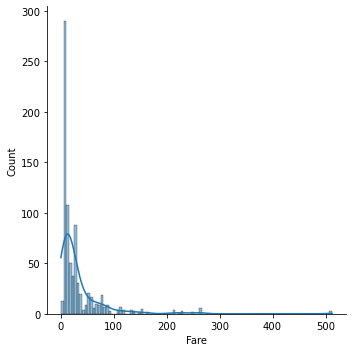

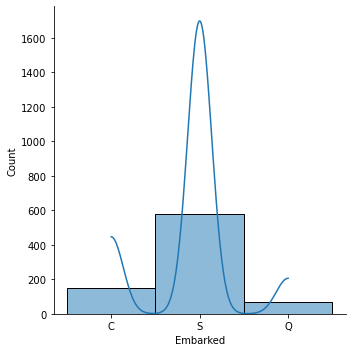

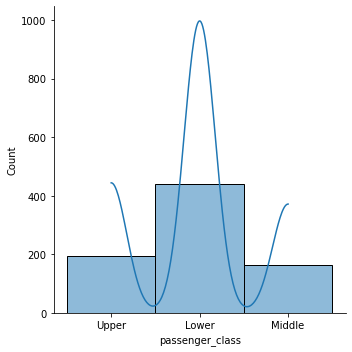

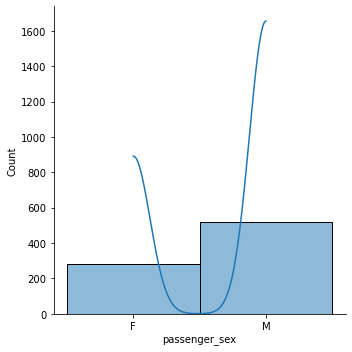

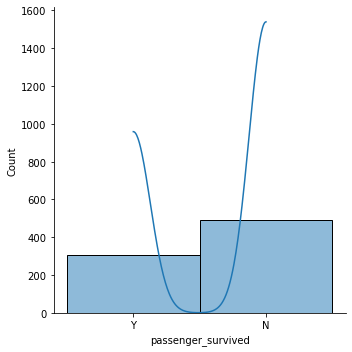

In [10]:
for columna in train.columns:
    sns.displot(train, x=columna, kde=True)
    

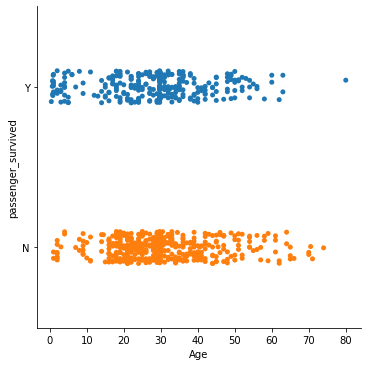

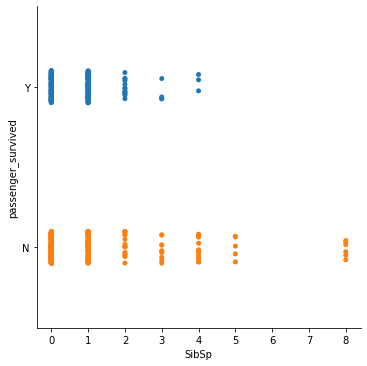

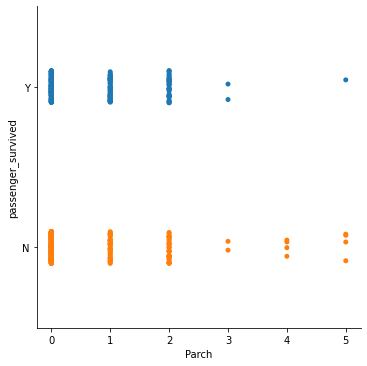

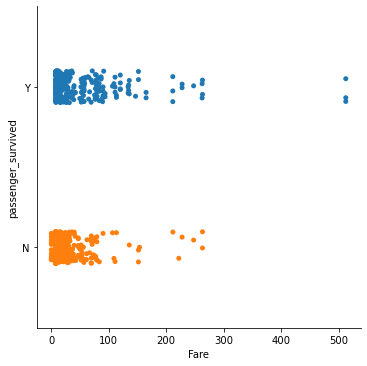

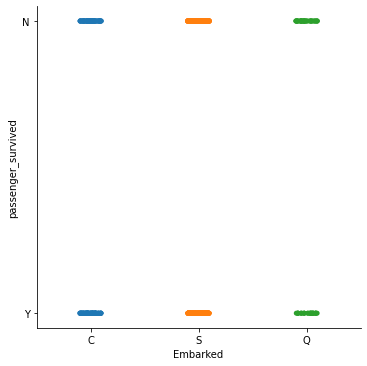

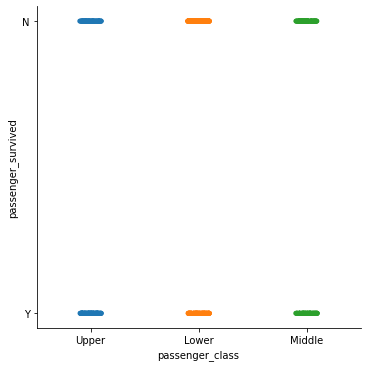

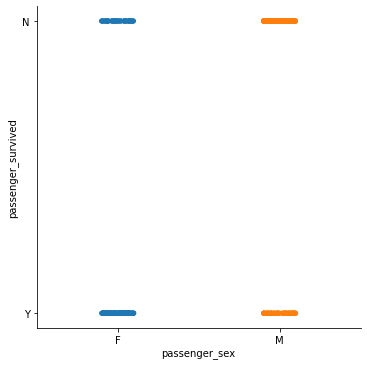

In [11]:
for columna in train.columns[0:-1]:
    sns.catplot(x=columna, y="passenger_survived", data=train)

## Correlacion de variables continuas

<AxesSubplot:>

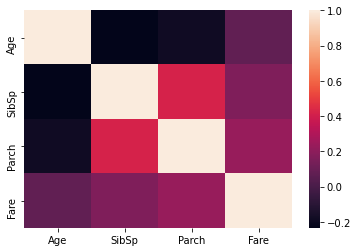

In [12]:
sns.heatmap(train.corr())
# Existe una correlacion lineal entre Parch y SibSp

## Codificacion de variables categoricas
### Para Embarked se utilizara OHE ya que no existe una relacion de ponderacion entre cada una de sus clases
### Para passenger_class se utilizara Label Encoding ordenado ya que las clases sugieren un tipo de ponderacion entre estas
### Para passenger_sex se utilizara OHE ya que no existe una relacion de ponderacion entre cada una de sus clases
### Para variable objetivo passenger_survived se utilizara Label Encoding (N=0, Y=1)


In [13]:
def cat_coding(data):
    data_res = data.copy()
    if data_res.columns.isin(['Embarked']).any():
        ohe_embarked = pd.get_dummies(data_res['Embarked'], sparse=True, prefix='embarked', prefix_sep='_')
        data_res = data_res.drop('Embarked', axis=1)
        data_res = data_res.join(ohe_embarked)
    if data_res.columns.isin(['passenger_class']).any():
        le_pass_class = preprocessing.LabelEncoder()
        le_pass_class.classes = np.array(['Lower','Middle','Upper'])
        data_res['passenger_class'] = le_pass_class.fit_transform(data_res['passenger_class'])
    if data_res.columns.isin(['passenger_sex']).any():
        ohe_sex = pd.get_dummies(data_res['passenger_sex'], sparse=True, prefix='sex', prefix_sep='_')
        data_res = data_res.drop('passenger_sex', axis=1)
        data_res = data_res.join(ohe_sex)
    if data_res.columns.isin(['passenger_survived']).any():
        le_survived_class = preprocessing.LabelEncoder()
        le_survived_class.classes = np.array(['N','Y'])
        data_res['passenger_survived'] = le_survived_class.fit_transform(data_res['passenger_survived'])
        data_res['passenger_survived'] = le_survived_class.fit_transform(data_res['passenger_survived'])
    return data_res

# Entrenamiento de Modelos
### Funcion de escritura en Bitacora de Experimentos

In [14]:
import csv
def save_experiment(file_name, row_elements):
    with open(file_name, mode='a+', newline='\n') as experiment_file:
        experiment_writer = csv.writer(experiment_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        experiment_writer.writerow(row_elements)

## Split de datos de entrenamiento y validacion

In [25]:
train_m1, validation_m1 = train_test_split(train, test_size=0.2, random_state =1)
train_m2, validation_m2 = train_test_split(train, test_size=0.2, random_state =2)
train_m3, validation_m3 = train_test_split(train, test_size=0.2, random_state =3)
train_m4, validation_m4 = train_test_split(train, test_size=0.2, random_state =4)


## Decision Tree

In [28]:

def train_DecisionTree(train_data, validation_data, variables, cost, max_features=None):
    experiment_str = 'DecisionTree_Cost='+cost+'_MaxFeatures='+str(max_features)+'_Vars=' + '-'.join(variables)
    variables.append('passenger_survived')
    train_m1 = cat_coding(train_data.loc[:,variables])
    validation_m1 = cat_coding(validation_data.loc[:,variables])

    train_m1_X = np.array(train_m1[train_m1.columns[~train_m1.columns.isin(['passenger_survived'])]])
    train_m1_Y = np.array(train_m1[train_m1.columns[train_m1.columns.isin(['passenger_survived'])]])

    validation_m1_X = np.array(validation_m1[validation_m1.columns[~validation_m1.columns.isin(['passenger_survived'])]])
    validation_m1_Y = np.array(validation_m1[validation_m1.columns[validation_m1.columns.isin(['passenger_survived'])]])

    modelo1 = DecisionTreeClassifier(criterion=cost, random_state=0, max_features=max_features)
    modelo1.fit(train_m1_X, train_m1_Y)

    y_hat = modelo1.predict(validation_m1_X)


    accuracy = metrics.accuracy_score(validation_m1_Y, y_hat)
    error = 1-metrics.accuracy_score(validation_m1_Y, y_hat)
    precision = metrics.precision_score(validation_m1_Y, y_hat)
    recall = metrics.recall_score(validation_m1_Y, y_hat)
    f1 = metrics.f1_score(validation_m1_Y, y_hat)
    now = datetime.now()
    save_experiment('Bitacora Experimentos - DT.csv', [str(now),experiment_str,accuracy,error,precision,recall,f1])

    return [modelo1, np.array([accuracy,error,precision,recall,f1])]

In [26]:
variables = ['Age','passenger_class','passenger_sex']
modeloDecisionTree, metricasDecisionTree = train_DecisionTree(train_m1, validation_m1, variables, 'gini')
metricasDecisionTree

array([0.85      , 0.15      , 0.88      , 0.70967742, 0.78571429])

In [29]:
variables = ['Age','passenger_class','passenger_sex']
modeloDecisionTree, metricasDecisionTree = train_DecisionTree(train_m1, validation_m1, variables, 'entropy',0.6)
metricasDecisionTree

array([0.85625   , 0.14375   , 0.88235294, 0.72580645, 0.79646018])

### Mejor modelo de Decision Tree utilizando Age, passenger_class y passenger_sex utilizando como funcion de costo la entropia y con max_features del 60%

## Support Vector Machines (SVM)

In [30]:
def train_SVM(train_data, validation_data, variables, kernel='rbf', regularization=1.0, degree=0, gamma='scale'):
    experiment_str = 'SVM_Kernel='+kernel+'_Gamma='+gamma+'_Regularization='+str(regularization)+'_Degree='+str(degree)+'_Vars=' + '-'.join(variables)
    variables.append('passenger_survived')
    train_m1 = cat_coding(train_data.loc[:,variables])
    validation_m1 = cat_coding(validation_data.loc[:,variables])

    train_m1_X = np.array(train_m1[train_m1.columns[~train_m1.columns.isin(['passenger_survived'])]])
    train_m1_Y = np.array(train_m1[train_m1.columns[train_m1.columns.isin(['passenger_survived'])]].values.ravel())

    validation_m1_X = np.array(validation_m1[validation_m1.columns[~validation_m1.columns.isin(['passenger_survived'])]])
    validation_m1_Y = np.array(validation_m1[validation_m1.columns[validation_m1.columns.isin(['passenger_survived'])]].values.ravel())
    modelo1 = SVC(kernel=kernel, C=regularization, degree=degree, gamma=gamma)
    modelo1.fit(train_m1_X, train_m1_Y)

    y_hat = modelo1.predict(validation_m1_X)


    accuracy = metrics.accuracy_score(validation_m1_Y, y_hat)
    error = 1-metrics.accuracy_score(validation_m1_Y, y_hat)
    precision = metrics.precision_score(validation_m1_Y, y_hat)
    recall = metrics.recall_score(validation_m1_Y, y_hat)
    f1 = metrics.f1_score(validation_m1_Y, y_hat)
    now = datetime.now()
    save_experiment('Bitacora Experimentos - SVM.csv', [str(now),experiment_str,accuracy,error,precision,recall,f1])

    return [modelo1, np.array([accuracy,error,precision,recall,f1])]

In [55]:
variables = ['Age','SibSp','Parch','Fare','passenger_sex']
modeloSVM, metricasSVM = train_SVM(train_m2, validation_m2, variables,kernel='poly', regularization=1.0, degree=2, gamma='auto')
metricasSVM

array([0.8625    , 0.1375    , 0.84482759, 0.79032258, 0.81666667])

### Mejor modelo de SVM utilizando Age, SibSp, Parch, Fare y passenger_sex utilizando un kernel polinomial de grado 2, regularizacion de 1.0 y gamma de 1/n_features (auto)

## Naive Bayes

In [414]:
class NaiveBayes_Classifier:
    def fit(self, train_data):
        vars_categoricas = train_data.columns[~train_data.columns.isin(['Age','Fare','passenger_survived'])]
        vars_continuas = train_data.columns[train_data.columns.isin(['Age','Fare'])]
        self._labels = np.unique(train_data['passenger_survived'])
        n_labels = len(self._labels)
        self._Py = train_data['passenger_survived'].value_counts()/len(train_data)
        self._stats_categoricas = self.stats_categoricas(train_data)
        self._stats_continuas = self.stats_continuas(train_data)

    def predict(self, test_data):
        probs = self.probs_categoricas(test_data) * self.probs_continuas(test_data)     # P(x1|y)*P(x2|y)*P(x2|y)*...*P(xn|y)
        probs['N'] *= self._Py.iloc[0]
        probs['Y'] *= self._Py.iloc[1]
        return probs.idxmax(axis=1)

    def stats_categoricas(self, data):
        vars_categoricas = data.columns[~data.columns.isin(['Age','Fare','passenger_survived'])]
        probs_categoricas = dict()

        for columna in vars_categoricas:
            frecuencia = pd.crosstab(index=data['passenger_survived'], columns=data[columna], margins=True)
            frecuencia.columns = np.append(np.unique(data[columna]), 'RowTotal')
            frecuencia.index = np.append(np.unique(data['passenger_survived']), 'ColTotal')
            probs_categoricas[columna]=frecuencia.div(frecuencia["RowTotal"],axis=0)
        return probs_categoricas

    def stats_continuas(self, data):
        vars_continuas = data.columns[data.columns.isin(['Age','Fare','passenger_survived'])]
        labels = np.unique(data['passenger_survived'])
        stats_continuas = dict()

        for columna in vars_continuas[vars_continuas != 'passenger_survived']:
            stats = []
            for label in labels:
                media = np.mean(data.loc[data['passenger_survived'] == label, columna])
                varianza = np.var(data.loc[data['passenger_survived'] == label, columna])
                stats.append([media, varianza])
            stats_continuas[columna] = stats
        return stats_continuas

    def probs_categoricas(self, data):
        probs = pd.DataFrame(np.ones((data.shape[0], 2)), columns=['N','Y'])

        for columna in data.columns[~data.columns.isin(['Age','Fare','passenger_survived'])]:
            temp1 = pd.DataFrame(data[columna])
            temp2 = pd.DataFrame(self._stats_categoricas[columna].iloc[0]).drop('RowTotal')
            temp3 = pd.DataFrame(self._stats_categoricas[columna].iloc[1]).drop('RowTotal')
            temp2[columna] = temp2.index.astype(data[columna].dtype)
            temp3[columna] = temp3.index.astype(data[columna].dtype)
            probs *= temp1.merge(temp2, on=columna).merge(temp3, on=columna).drop(columna, axis=1)      # P(x1|y)*P(x2|y)*P(x2|y)*...*P(xn|y)
        return probs

    def probs_continuas(self, data):
        probs = pd.DataFrame(np.ones((data.shape[0], 2)), columns=['N','Y'])
        probs.index = data.index

        for columna in data.columns[data.columns.isin(['Age','Fare'])]:
            temp1 = data[data.columns[data.columns.isin([columna])]]
            stats = pd.DataFrame(self._stats_continuas[columna], index=['N','Y'])
            pdf_N = np.exp(-((temp1 - stats.iloc[0][0]) ** 2) / (2 * stats.iloc[0][1])) / np.sqrt(2*np.pi*stats.iloc[0][1])
            pdf_Y = np.exp(-((temp1 - stats.iloc[1][0]) ** 2) / (2 * stats.iloc[1][1])) / np.sqrt(2*np.pi*stats.iloc[1][1])
            pdf_N.columns = ['N']
            pdf_Y.columns = ['Y']
            pdf = pd.concat([pdf_N, pdf_Y], axis=1)
            probs *= pdf                                                                                # P(x1|y)*P(x2|y)*P(x2|y)*...*P(xn|y)
        return probs.reset_index(drop=True)


In [465]:
variables = ['SibSp','Parch','Fare','passenger_class','passenger_sex']
experiment_str = 'NB_Vars='+'-'.join(variables)
variables.append('passenger_survived')
nb = NaiveBayes_Classifier()
nb.fit(train_m3[variables])
y_hat = nb.predict(validation_m3[variables])

accuracy = metrics.accuracy_score(validation_m3['passenger_survived'], y_hat)
error = 1-metrics.accuracy_score(validation_m3['passenger_survived'], y_hat)
precision = metrics.precision_score(validation_m3['passenger_survived'], y_hat, pos_label='Y')
recall = metrics.recall_score(validation_m3['passenger_survived'], y_hat, pos_label='Y')
f1 = metrics.f1_score(validation_m3['passenger_survived'], y_hat, pos_label='Y')
now = datetime.now()
save_experiment('Bitacora Experimentos - NB.csv', [str(now),experiment_str,accuracy,error,precision,recall,f1])
print([accuracy,error,precision,recall,f1])

[0.65625, 0.34375, 0.4909090909090909, 0.5, 0.4954128440366972]


Normalizacion de variables continuas usando norma L1

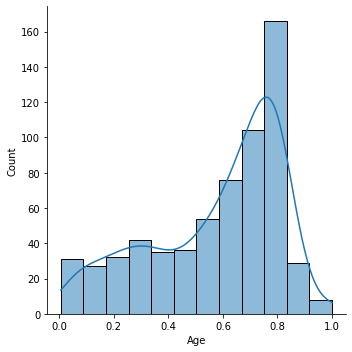

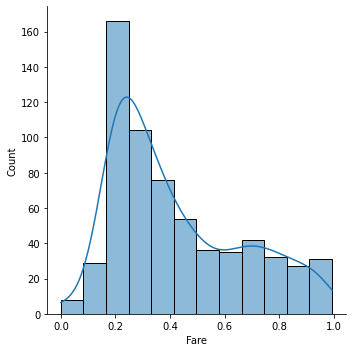

In [509]:
norm_data = pd.DataFrame(preprocessing.normalize(train_m3.loc[:,['Age','Fare']], norm='l1'), columns=['Age', 'Fare'], index=train_m3.loc[:,['Age','Fare']].index)
norm_train = train_m3.copy()
norm_train['Age'] = norm_data.loc[:,'Age']
norm_train['Fare'] = norm_data.loc[:,'Fare']
norm_train
for columna in ['Age','Fare']:
    sns.displot(norm_train, x=columna, kde=True)

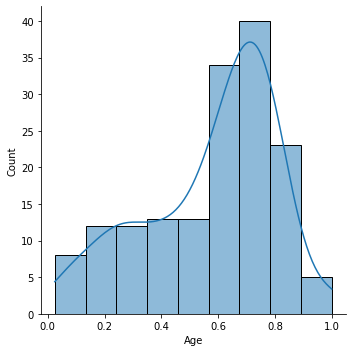

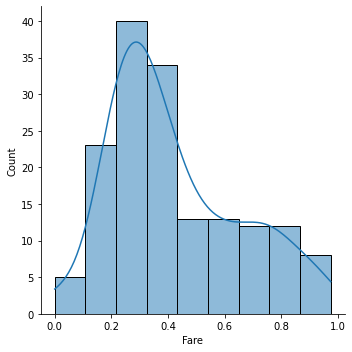

In [510]:
norm_data = pd.DataFrame(preprocessing.normalize(validation_m3.loc[:,['Age','Fare']], norm='l1'), columns=['Age', 'Fare'], index=validation_m3.loc[:,['Age','Fare']].index)
norm_validation = validation_m3.copy()
norm_validation['Age'] = norm_data.loc[:,'Age']
norm_validation['Fare'] = norm_data.loc[:,'Fare']
norm_validation
for columna in ['Age','Fare']:
    sns.displot(norm_validation, x=columna, kde=True)

In [519]:
variables = ['Age','SibSp','Parch','Fare','passenger_class','passenger_sex']
experiment_str = 'NB_NormL1_Vars='+'-'.join(variables)
variables.append('passenger_survived')
nb = NaiveBayes_Classifier()
nb.fit(norm_train[variables])
y_hat = nb.predict(norm_validation[variables])

accuracy = metrics.accuracy_score(norm_validation['passenger_survived'], y_hat)
error = 1-metrics.accuracy_score(norm_validation['passenger_survived'], y_hat)
precision = metrics.precision_score(norm_validation['passenger_survived'], y_hat, pos_label='Y')
recall = metrics.recall_score(norm_validation['passenger_survived'], y_hat, pos_label='Y')
f1 = metrics.f1_score(norm_validation['passenger_survived'], y_hat, pos_label='Y')
now = datetime.now()
save_experiment('Bitacora Experimentos - NB.csv', [str(now),experiment_str,accuracy,error,precision,recall,f1])
print([accuracy,error,precision,recall,f1])

[0.68125, 0.31875, 0.5217391304347826, 0.6666666666666666, 0.5853658536585366]


### Mejor modelo de NB utilizando Age, SibSp, Parch, Fare, passenger_class y passenger_sex utilizando un normalizacion L1 en features continuas

## Regresion Logistica con regularizacion